# Import the Dataset

In [ ]:
!unzip /content/shai-training-multi-label.zip

# Importing the libraries

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
train_folder = '/content/train'

In [ ]:
labels = ['black', 'blue', 'brown', 'green','red', 'white', 'dress','pants','shirt', 'shoes','shorts']

In [ ]:

data = []
for root, _, files in os.walk(train_folder):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_path = os.path.join(root, file)
            labels_encoded = [0] * len(labels)
            image_labels = root.split(os.sep)[-1].split('_')
            for label_component in image_labels:
                if label_component in labels:
                    labels_encoded[labels.index(label_component)] = 1
            label_list = [labels[i] for i, val in enumerate(labels_encoded) if val == 1]
            row = [os.path.basename(image_path)] + labels_encoded + [label_list]
            data.append(row)

In [ ]:
csv_filename = '/content/training_data.csv'

In [ ]:
with open(csv_filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image'] + labels + ['Labels'])
    writer.writerows(data)

In [ ]:
train_set = pd.read_csv('training_data.csv')
train_set.head()

,Image,black,blue,brown,green,red,white,dress,pants,shirt,shoes,shorts,Labels
0,d98d6858fb2293316e6ce20604cb7a1342034b9b.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"
1,e22b1c6a2cf0fc4fb2dc87ec8bd43db9fab7ca76.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"
2,0ef17ad06d822f45c95645025bbf9821c6e85562.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"
3,38bc4fcb910aa246e67d86b9b58b2eda2c1a16a5.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"
4,d3038144e20146257c7fa0aa127d0b15cef5a05e.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"


In [ ]:
train_set.columns

Index(['Image', 'black', 'blue', 'brown', 'green', 'red', 'white', 'dress',
       'pants', 'shirt', 'shoes', 'shorts', 'Labels'],
      dtype='object')

# Loading and Preprocessing the data

In [ ]:
import os
import shutil

train_folder = '/content/train'
output_folder = '/content/Multi_Label_dataset/Images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over the subfolders in the train folder
for folder_name in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder_name)
    if os.path.isdir(folder_path):
        # Iterate over the files in each subfolder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                # Copy the file to the output folder
                shutil.copy(file_path, output_folder)

In [ ]:
train_image = []
for i in tqdm(range(train_set.shape[0])):
    img = image.load_img('Multi_Label_dataset/Images/'+train_set['Image'][i], target_size=(128, 128, 3))
    img = image.img_to_array(img)
    img = img / 255
    train_image.append(img)

100%|██████████| 10246/10246 [00:38<00:00, 267.18it/s]


In [ ]:
X = np.array(train_image)

In [ ]:
# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)


In [ ]:
X.shape

(10246, 128, 128, 3)

In [ ]:
# Split the data into train and test sets
y = np.array(train_set.drop(['Image', 'Labels'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [ ]:
# Apply image augmentation to the data
datagen.fit(X_train)

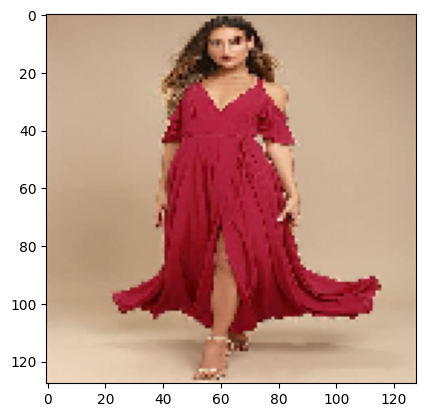

In [ ]:
plt.imshow(X_train[4])

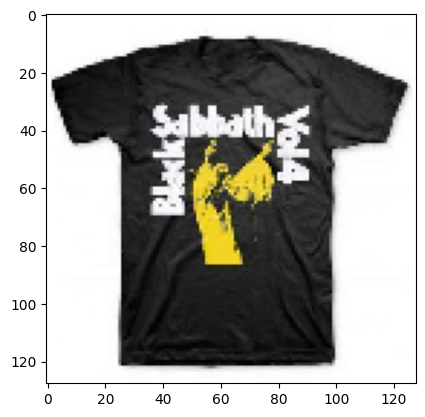

In [ ]:
plt.imshow(X_test[4])

# Build the Model

In [ ]:

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(11, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 128)       7

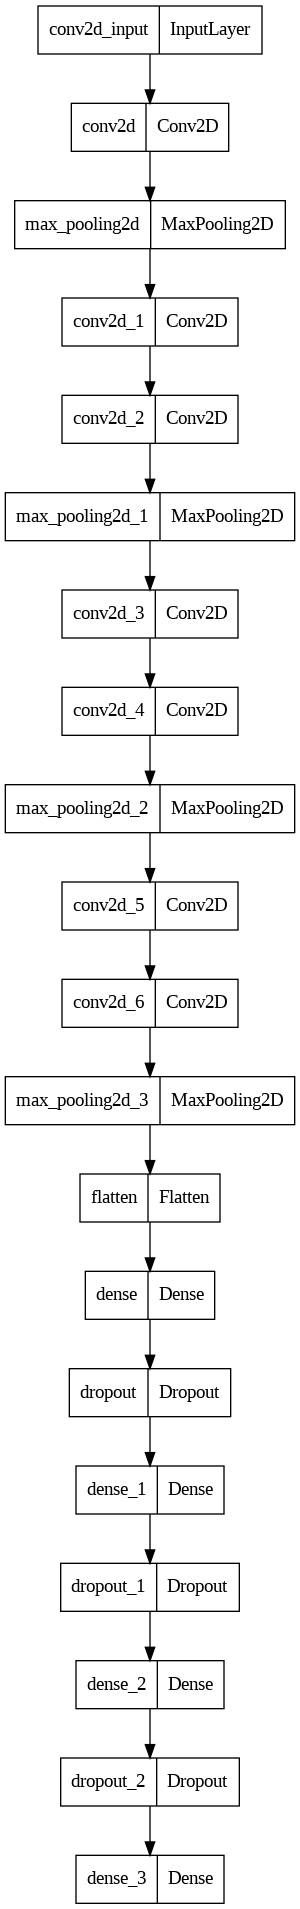

In [ ]:
tf.keras.utils.plot_model(model)

# Compile and Train the Model

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=7,
                                          min_delta=0.001,
                                          restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, verbose=1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=[early, reduce_lr])


Epoch 1/10
288/288 [==============================] - 54s 137ms/step - loss: 0.4094 - accuracy: 0.3785 - val_loss: 0.2911 - val_accuracy: 0.7932 - lr: 0.0010
Epoch 2/10
288/288 [==============================] - 40s 139ms/step - loss: 0.2733 - accuracy: 0.8111 - val_loss: 0.2101 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 3/10
288/288 [==============================] - 38s 134ms/step - loss: 0.2283 - accuracy: 0.8143 - val_loss: 0.1572 - val_accuracy: 0.8820 - lr: 0.0010
Epoch 4/10
288/288 [==============================] - 38s 133ms/step - loss: 0.2005 - accuracy: 0.8240 - val_loss: 0.1495 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 5/10
288/288 [==============================] - 38s 133ms/step - loss: 0.1854 - accuracy: 0.8196 - val_loss: 0.1361 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 6/10
288/288 [==============================] - 38s 132ms/step - loss: 0.1736 - accuracy: 0.8110 - val_loss: 0.1307 - val_accuracy: 0.8459 - lr: 0.0010
Epoch 7/10
288/288 [==============================] 

# Plotting the Model Metrics

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


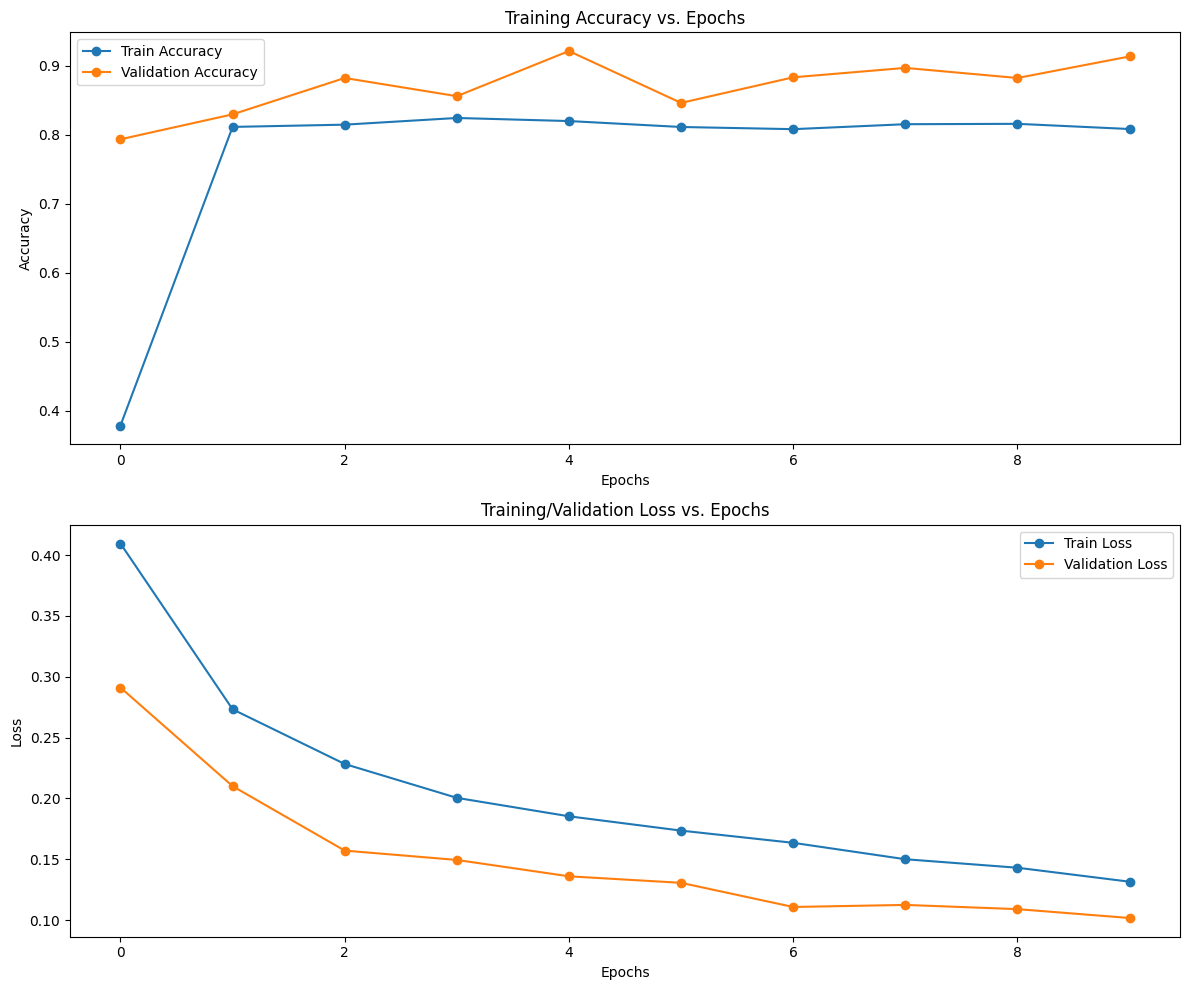

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Model Prediction on the Test Dataset

In [ ]:
!unzip /content/Labeled_Test.zip

In [ ]:
test_folder = '/content/Labeled_Test'

In [ ]:
labels = ['black', 'blue', 'brown', 'green','red', 'white', 'dress','pants','shirt', 'shoes','shorts']
data = []
for root, _, files in os.walk(test_folder):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_path = os.path.join(root, file)
            labels_encoded = [0] * len(labels)
            image_labels = root.split(os.sep)[-1].split('_')
            for label_component in image_labels:
                if label_component in labels:
                    labels_encoded[labels.index(label_component)] = 1
            label_list = [labels[i] for i, val in enumerate(labels_encoded) if val == 1]
            row = [os.path.basename(image_path)] + labels_encoded + [label_list]
            data.append(row)

In [ ]:
csv_filename = '/content/testing_data.csv'
with open(csv_filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image'] + labels + ['Labels'])
    writer.writerows(data)

In [ ]:
test_set = pd.read_csv('testing_data.csv')
test_set.head()

,Image,black,blue,brown,green,red,white,dress,pants,shirt,shoes,shorts,Labels
0,a68ddd8a6f45ba18486e793ff2e4c90c62cc2d81.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"
1,89053b8c26445d11975d4dccf7d48b03470e1fc0.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"
2,074cfb8a95d57d0c9f4d4717446982e9282e9b5d.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"
3,323464a2c2595626df21ac146e3911920bceab3c.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"
4,048fb3c98fac7811e45824d6f6311dc69dca52f3.jpg,0,0,0,1,0,0,0,1,0,0,0,"['green', 'pants']"


In [ ]:
import os
import shutil

test_folder = '/content/Labeled_Test'
output_folder = '/content/Test_dataset/Images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate over the subfolders in the train folder
for folder_name in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder_name)
    if os.path.isdir(folder_path):
        # Iterate over the files in each subfolder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                # Copy the file to the output folder
                shutil.copy(file_path, output_folder)

In [ ]:
test_image = []
for i in tqdm(range(test_set.shape[0])):
    img = image.load_img('Test_dataset/Images/'+test_set['Image'][i], target_size=(128, 128, 3))
    img = image.img_to_array(img)
    img = img / 255
    test_image.append(img)

100%|██████████| 1139/1139 [00:04<00:00, 269.21it/s]


In [ ]:
X_test = np.array(test_image)

In [ ]:
predictions = model.predict(X_test)

36/36 [==============================] - 1s 18ms/step


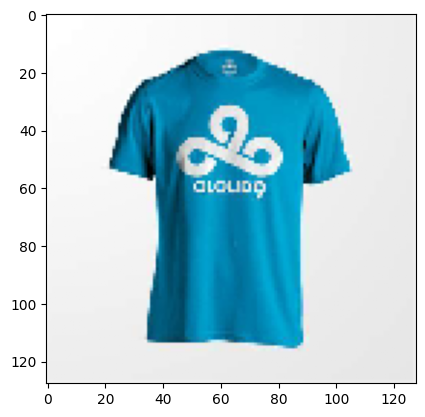

In [ ]:
plt.imshow(X_test[4])

# Model Evaluation on the Test dataset

In [ ]:
y = np.array(test_set.drop(['Image', 'Labels'],axis=1))

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y)

# Print the test loss and accuracy
print('Test Loss: {:.3f}'.format(test_loss))
print('Test Accuracy: {:.2%}'.format(test_accuracy))

36/36 [==============================] - 0s 12ms/step - loss: 0.1099 - accuracy: 0.9069
Test Loss: 0.110
Test Accuracy: 90.69%


In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y, axis=1)

## Plot Sample of the predicting set

Predictions for Image 7:
green (0.994)
shorts (0.709)
shirt (0.165)
--------------------
Predictions for Image 8:
green (0.998)
pants (0.766)
shirt (0.118)
--------------------
Predictions for Image 9:
green (0.987)
shorts (0.551)
pants (0.241)
--------------------
Predictions for Image 10:
green (1.0)
pants (0.954)
shorts (0.0182)
--------------------
Predictions for Image 11:
green (1.0)
pants (0.915)
shorts (0.0338)
--------------------
Predictions for Image 12:
green (0.991)
shoes (0.389)
shorts (0.347)
--------------------


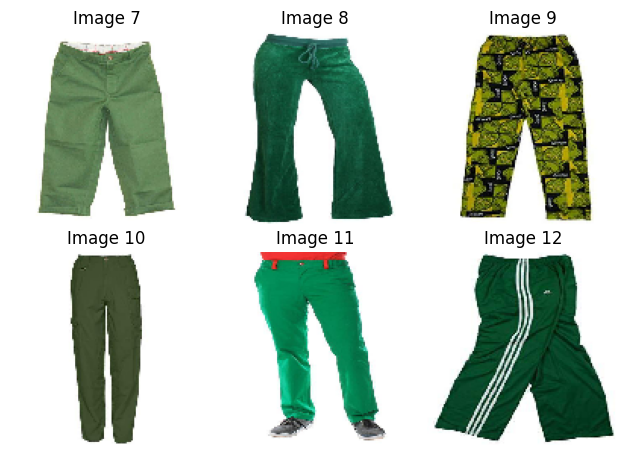

In [ ]:

num_images = 6

classes = np.array(test_set.columns[1:-1])
proba = predictions

for i in range(num_images, num_images + 6):
    top_3 = np.argsort(proba[i])[:-4:-1]
    img = test_image[i]  # Assuming test_image contains the images

    plt.subplot(2, 3, i - num_images + 1)  # Create a subplot for each image
    plt.imshow(img)
    plt.title("Image {}".format(i+1))
    plt.axis('off')

    plt.subplots_adjust(top=1)  # Adjust the top spacing for titles

    print("Predictions for Image {}:".format(i+1))
    for j in range(3):
        print("{} ({:.3})".format(classes[top_3[j]], proba[i][top_3[j]]))
    print("--------------------")

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

## Build the Confusion Matrix

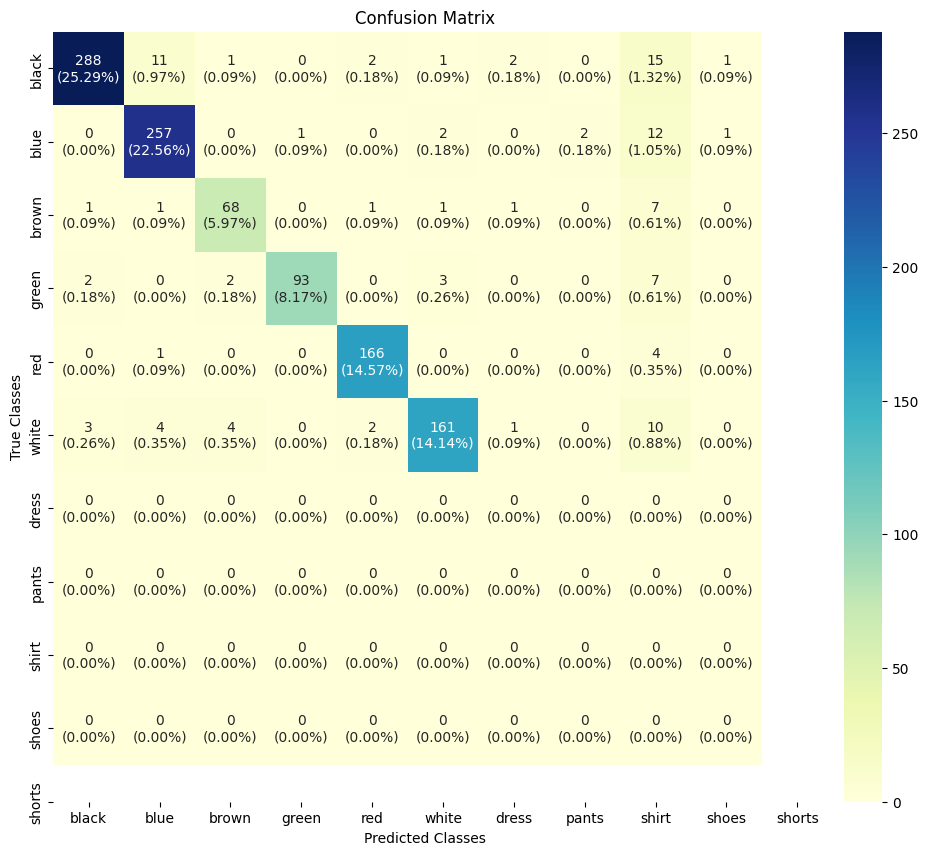

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten() / np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape[0], cf_mtx.shape[1])

plt.figure(figsize=(12, 10))
sns.heatmap(cf_mtx, xticklabels=label_names, yticklabels=label_names,
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()

# Make A single Prediction

In [ ]:
img = image.load_img('/content/istockphoto-912931370-612x612.jpg',target_size=(128,128,3))
img = image.img_to_array(img)
img = img/255

1/1 [==============================] - 0s 21ms/step
white (0.988)
dress (0.935)
shorts (0.0439)


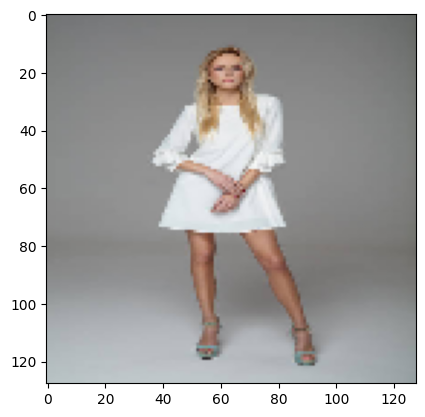

In [ ]:
classes = np.array(train_set.columns[1:-1])
proba = model.predict(img.reshape(1,128,128,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)



---



---



---

